## References
- https://www.codementor.io/jadianes/building-a-recommender-with-apache-spark-python-example-app-part1-du1083qbw

## Load MovieLens data

In [1]:
complete_dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip'
small_dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.sparse as sparse

%matplotlib inline

Let's start with the ratings data

In [2]:
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
ratings.userId.nunique(), ratings.movieId.nunique()

(671, 9066)

We have 671 unique users and 9066 unique items. Let's see how many movies each user have rated

In [5]:
ratings = ratings[["userId", "movieId", "rating"]]

In [7]:
data = ratings.groupby("userId", as_index=False).agg({"movieId": 'count'})

In [8]:
data.head()

,userId,movieId
0,1,20
1,2,76
2,3,51
3,4,204
4,5,100


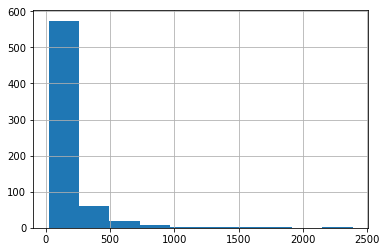

In [9]:
data.movieId.hist()

In [10]:
data.movieId.describe()

count     671.000000
mean      149.037258
std       231.226948
min        20.000000
25%        37.000000
50%        71.000000
75%       161.000000
max      2391.000000
Name: movieId, dtype: float64

On average, users rated 149 movies. All users have rated at least 20 movies

In [20]:
movies = pd.read_csv("data/ml-latest-small/movies.csv")

In [21]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


This data will be helpful to match movieId with the movie title

Now, let's make a user item interaction matrix. A user item interaction matrix is where each user is represented by a vector of length the number of unique items. From our ratings data, we convert each row into the specific user and item interaction and 0 everywhere else

In [33]:
users = list(np.sort(ratings.userId.unique())) # Get our unique customers
movies = list(ratings.movieId.unique()) # Get our unique products that were purchased
rating = list(ratings.rating) # All of our purchases

rows = ratings.userId.astype('category', categories = users).cat.codes 
# Get the associated row indices
cols = ratings.movieId.astype('category', categories = movies).cat.codes 
# Get the associated column indices
user_item = sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(movies)))

In [34]:
matrix_size = user_item.shape[0]*user_item.shape[1] # Number of possible interactions in the matrix
num_purchases = len(user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (1.0*num_purchases/matrix_size))
sparsity

98.35608583913366

In [35]:
user_item

<671x9066 sparse matrix of type '<type 'numpy.float64'>'
	with 100004 stored elements in Compressed Sparse Row format>

The user item matrix has 671 unique users and 9066 unique movies which checks with what we found earlier in our data exploration. This matrix is 98.35% sparse which seems too low but it should be usable for the ALS algorithm that we will use.